In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

path = os.getcwd()
file_path = os.path.join(path,"file")
sub_path = os.path.join(path,"제출")
train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))

In [2]:
display(train_df.head())

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [16]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [3]:
from pytimekr import pytimekr
import datetime

List_holiday = []
for i in range(5,1551,7):
    List_holiday.append((datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d"))
    
for i in range(2019,2024):
    List_holiday.extend(pytimekr.holidays(year=i)) #리스트 형태로 반환

for i in range(len(List_holiday)):
    List_holiday[i] = str(List_holiday[i])
np.sort(List_holiday)

array(['2019-01-01', '2019-01-06', '2019-01-13', '2019-01-20',
       '2019-01-27', '2019-02-03', '2019-02-04', '2019-02-05',
       '2019-02-06', '2019-02-10', '2019-02-17', '2019-02-24',
       '2019-03-01', '2019-03-03', '2019-03-10', '2019-03-17',
       '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
       '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-05',
       '2019-05-12', '2019-05-12', '2019-05-19', '2019-05-26',
       '2019-06-02', '2019-06-06', '2019-06-09', '2019-06-16',
       '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
       '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
       '2019-08-15', '2019-08-18', '2019-08-25', '2019-09-01',
       '2019-09-08', '2019-09-12', '2019-09-13', '2019-09-14',
       '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-03',
       '2019-10-06', '2019-10-09', '2019-10-13', '2019-10-20',
       '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
       '2019-11-24', '2019-12-01', '2019-12-08', '2019-

In [4]:
train_df.loc[train_df['timestamp'].isin(List_holiday)==True,'Holiday']=0
train_df.loc[train_df['timestamp'].isin(List_holiday)==False,'Holiday']=1
test_df.loc[test_df['timestamp'].isin(List_holiday)==True,'Holiday']=0
test_df.loc[test_df['timestamp'].isin(List_holiday)==False,'Holiday']=1

In [5]:
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_df[i]=le.fit_transform(train_df[i])
    test_df[i]=le.transform(test_df[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

print('Done.')

Done.


In [17]:
train_df.corr()

C:\Users\USER\AppData\Local\Temp\ipykernel_22636\1233823885.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.corr()


,item,corporation,location,supply(kg),price(원/kg),Holiday,year,month,day
item,1.000000e+00,4.072922e-02,1.021213e-01,0.121105,0.354497,4.786837e-15,-6.709749e-12,-6.455688e-15,-9.002369e-16
corporation,4.072922e-02,1.000000e+00,-8.724446e-02,0.177966,-0.090228,-1.740782e-15,1.973653e-12,5.308075e-16,1.945824e-15
location,1.021213e-01,-8.724446e-02,1.000000e+00,-0.071984,0.040949,3.985854e-17,5.565214e-14,5.590797e-16,-5.240705e-16
supply(kg),1.211047e-01,1.779656e-01,-7.198399e-02,1.000000,-0.002297,9.373570e-02,2.427792e-02,-1.205799e-01,1.613396e-04
price(원/kg),3.544971e-01,-9.022765e-02,4.094871e-02,-0.002297,1.000000,2.255803e-01,2.944230e-02,-7.667260e-02,1.175532e-02
Holiday,4.786837e-15,-1.740782e-15,3.985854e-17,0.093736,0.225580,1.000000e+00,1.130435e-03,1.721472e-02,4.251375e-02
year,-6.709749e-12,1.973653e-12,5.565214e-14,0.024278,0.029442,1.130435e-03,1.000000e+00,-1.145409e-01,-1.042559e-02
month,-6.455688e-15,5.308075e-16,5.590797e-16,-0.120580,-0.076673,1.721472e-02,-1.145409e-01,1.000000e+00,1.498942e-02
day,-9.002369e-16,1.945824e-15,-5.240705e-16,0.000161,0.011755,4.251375e-02,-1.042559e-02,1.498942e-02,1.000000e+00


In [23]:
train_x = train_df.drop(columns=['ID', 'timestamp','year', 'supply(kg)', 'price(원/kg)'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'timestamp','year'])

In [24]:
def minmaxscaler(data,Min=[],Max=[]):
    if len(Min)==0 and len(Max)==0:
        return (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0)), np.min(data,axis=0),np.max(data,axis=0)
    else:
        return (data-Min)/(Max-Min)
    
re_train_x,Min_train,Max_train = minmaxscaler(train_x)
re_test_x = minmaxscaler(test_x,Min_train,Max_train)

In [25]:
test_x

,item,corporation,location,Holiday,month,day
0,4,0,0,1.0,3,4
1,4,0,0,0.0,3,5
2,4,0,0,1.0,3,6
3,4,0,0,1.0,3,7
4,4,0,0,1.0,3,8
...,...,...,...,...,...,...
1087,3,5,0,1.0,3,27
1088,3,5,0,1.0,3,28
1089,3,5,0,1.0,3,29
1090,3,5,0,1.0,3,30


In [26]:
model = LGBMRegressor(random_state=0, max_depth=15, learning_rate=0.05,
                          subsample=0.6, n_estimators=2000)
model.fit(re_train_x, train_y,eval_metric="RMSE")

LGBMRegressor(learning_rate=0.05, max_depth=15, n_estimators=2000,
              random_state=0, subsample=0.6)

In [32]:
preds = model.predict(re_test_x)
preds[np.where((preds<0))[0]]=0

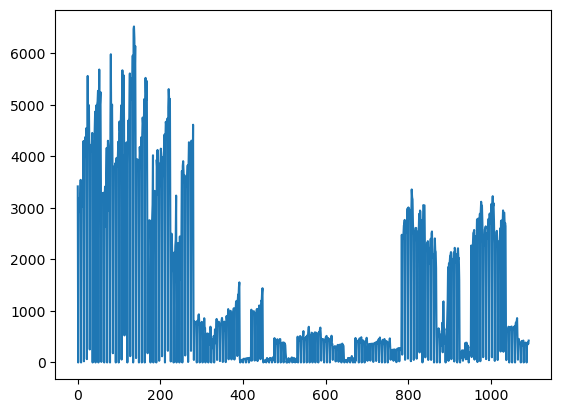

In [33]:
import matplotlib.pyplot as plt
plt.plot(preds)
plt.show()

In [34]:
submission = pd.read_csv(os.path.join(file_path,"sample_submission.csv"))
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [35]:
holiday_test = ["20230305","20230312","20230319","20230326"]
submission['answer'] = preds
submission.loc[submission['ID'].str.split("_").str[3].isin(holiday_test),"answer"] = 0
submission

,ID,answer
0,TG_A_J_20230304,3417.266965
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,3052.746599
3,TG_A_J_20230307,2972.047726
4,TG_A_J_20230308,2920.187555
...,...,...
1087,RD_F_J_20230327,336.792563
1088,RD_F_J_20230328,346.367389
1089,RD_F_J_20230329,389.121705
1090,RD_F_J_20230330,360.345566


In [36]:
submission.to_csv(os.path.join(sub_path,"baseline_submission21.csv"), index=False)